In [9]:
import os
import sys
#sys.path.insert(1, '../Src/')
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from umap import UMAP
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

PATH_DATA = '../../Data'

np.random.seed(42)

%matplotlib inline

In [10]:
pip install umap-learn

Note: you may need to restart the kernel to use updated packages.


In [11]:
fname = "stringer_spontaneous.npy"
fname =os.path.join(PATH_DATA,fname)

In [13]:
# @title Data loading
dat = np.load(fname, allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'istim', 'stat', 'u_spont', 'v_spont', 'mean_spont', 'std_spont', 'stimtimes', 'frametimes', 'camtimes', 'run', 'info', 'xyz'])


# neural activity vs run

In [14]:
X = dat['sresp'].T
X.shape

(4598, 23589)

In [15]:
y = dat['run']

### Normalization

In [17]:
X = (X-X.mean())/X.std()

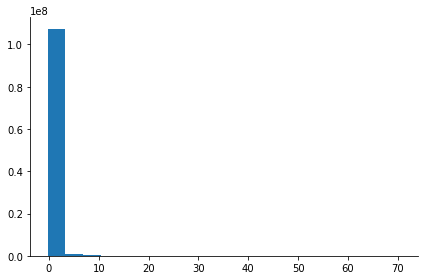

In [18]:
hist = plt.hist(X.flatten(),bins=20)

In [19]:

n = int(len(X)*0.3)

X_train = X[:-n]
y_train = y[:-n]

X_test  = X[-n:]
y_test  = y[-n:]
print('Train : ',X_train.shape)
print('Test  : ',X_test.shape)

Train :  (3219, 23589)
Test  :  (1379, 23589)


In [35]:
my_model = PCA(n_components=3000)
my_model.fit_transform(X_train)

array([[-9.93550111e+00,  9.29909181e+01, -2.92970020e+01, ...,
         5.67743346e-02, -1.87146744e-02,  1.53452407e-02],
       [ 3.04668223e+01, -3.27207318e+01,  2.88875166e+01, ...,
         2.99029534e-02,  6.80065008e-02,  1.23197349e-02],
       [-3.02648376e+01,  1.89201783e+01,  1.17742174e+01, ...,
        -2.03504492e-01, -6.42916893e-02, -2.64952907e-02],
       ...,
       [-3.02958814e+01, -2.42121271e+01,  3.40056964e-01, ...,
         5.94291776e-01, -1.41045015e-01,  4.65096490e-01],
       [-3.28835148e+01, -2.71520625e+00,  1.12245250e+01, ...,
         4.63168705e-01,  3.78715089e-02, -6.02906327e-01],
       [-1.80394608e+01, -2.40042554e+01, -2.54214985e+00, ...,
         2.21255167e-01, -1.68816208e-01,  6.35352257e-01]])

In [36]:
explained_variance_ratio_ = my_model.explained_variance_ratio_

In [37]:
explained_variance_ratio_[:4]

array([0.05568968, 0.04652237, 0.03648915, 0.03511896])

In [26]:
accumulate_explained_variance_ratio_ = np.cumsum(explained_variance_ratio_)

In [27]:
accumulate_explained_variance_ratio_[:4]

array([0.05568968, 0.10221205, 0.1387012 , 0.17382016])

Text(0, 0.5, 'sum explained_variance_ratio')

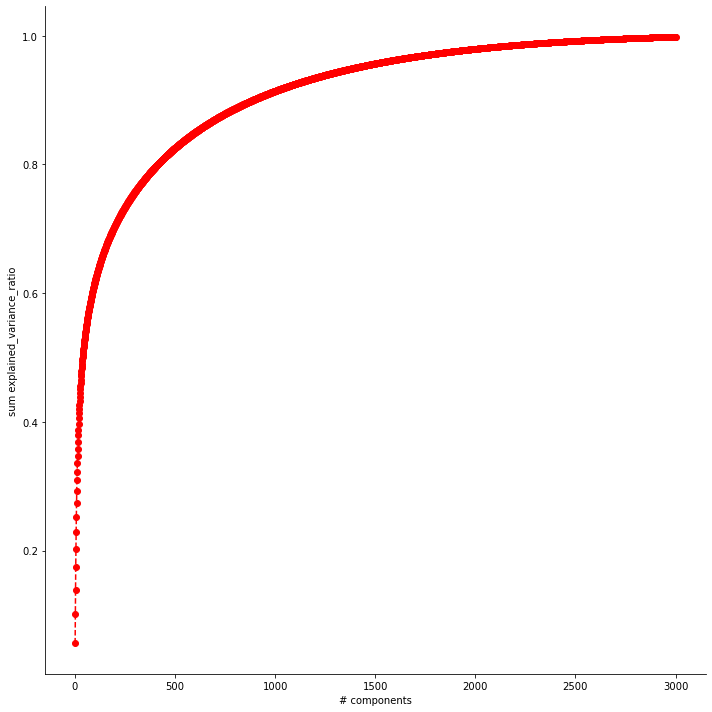

In [28]:
fig = plt.figure(figsize=(10,10))

plt.plot(range(1,len(accumulate_explained_variance_ratio_)+1),accumulate_explained_variance_ratio_,'--ro')

plt.xlabel("# components")
plt.ylabel("sum explained_variance_ratio")

In [29]:
accumulate_explained_variance_ratio_[2000]

0.9796907890970827

In [30]:
print('Train : ',X_train.shape)
print('Test  : ',X_test.shape)

Train :  (3219, 23589)
Test  :  (1379, 23589)


In [31]:
X_train_pca = my_model.transform(X_train)
X_test_pca  = my_model.transform(X_test)

In [32]:
print('Train PCA : ',X_train_pca.shape)
print('Test PCA  : ',X_test_pca.shape)

Train PCA :  (3219, 3000)
Test PCA  :  (1379, 3000)


## Linear Regression with positive and negative coefficients

In [20]:
my_model_LR_1 = LinearRegression(positive=False)
my_model_LR_1.fit(X_train_pca,y_train)

LinearRegression()

metric_train_R2  : 0.9513792733639549
metric_train_RMSE: 1.466736660419861
metric_test_R2  : 0.835164891772685
metric_test_RMSE: 4.264346994470361


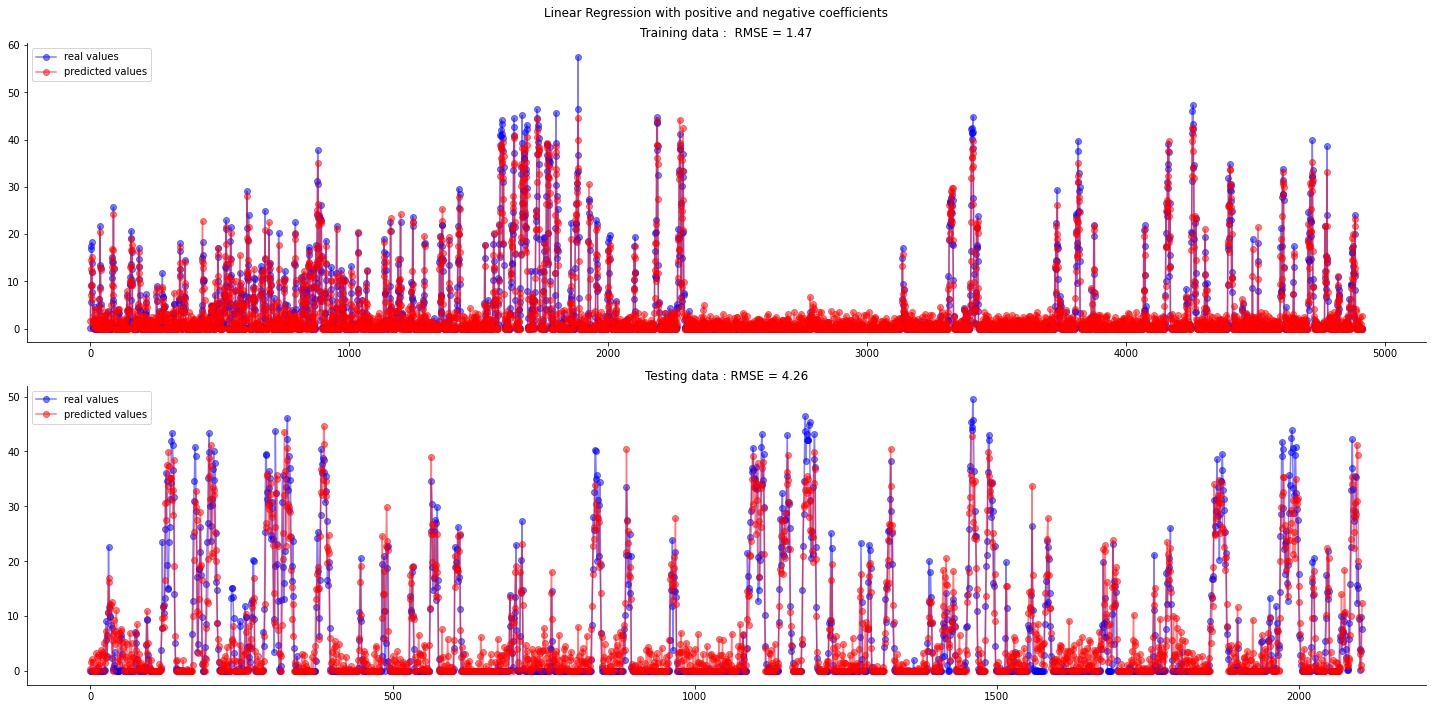

In [21]:
y_train_pred      = my_model_LR_1.predict(X_train_pca) # metric_train_RMSE: 2.4037369030804003e-05


y_train_pred[y_train_pred<=0] = 0  # metric_train_RMSE: 2.196909835364599e-05


metric_train_R2   = my_model_LR_1.score(X_train_pca, y_train)
metric_train_RMSE = mean_squared_error(y_train, y_train_pred, squared=False)

print("metric_train_R2  :",metric_train_R2)
print("metric_train_RMSE:",metric_train_RMSE)

fig = plt.figure(figsize=(20,10))


plt.subplot(2,1,1)
plt.plot(range(len(y_train)),y_train,'-bo',alpha=0.5,label='real values')
plt.plot(range(len(y_train_pred)),y_train_pred,'-ro',alpha=0.5,label='predicted values')

plt.legend(loc="upper left")
plt.title('Training data :  RMSE = '+str(np.round(metric_train_RMSE,2)))
#plt.show()


y_test_pred      = my_model_LR_1.predict(X_test_pca) # metric_test_RMSE: 5.73526388441703

y_test_pred[y_test_pred<=0] = 0 #metric_test_RMSE: 5.5218955408988


metric_test_R2   = my_model_LR_1.score(X_test_pca, y_test)
metric_test_RMSE = mean_squared_error(y_test, y_test_pred, squared=False)

print("metric_test_R2  :",metric_test_R2)
print("metric_test_RMSE:",metric_test_RMSE)

#fig = plt.figure(figsize=(20,5))
plt.subplot(2,1,2)
plt.plot(range(len(y_test)),y_test,'-bo',alpha=0.5,label='real values')
plt.plot(range(len(y_test_pred)),y_test_pred,'-ro',alpha=0.5,label='predicted values')
plt.title('Testing data : RMSE = '+str(np.round(metric_test_RMSE,2)))
plt.legend(loc="upper left")

plt.suptitle('Linear Regression with positive and negative coefficients')
plt.show()


In [22]:
%matplotlib inline

## Linear Regression with positive coefficients

In [43]:
my_model_LR_2 = LinearRegression(positive=True)# POSITIVE = False
my_model_LR_2.fit(X_train_pca,y_train)

LinearRegression(positive=True)

metric_train_R2  : 0.7214254732620564
metric_train_RMSE: 8.776655203745873
metric_test_R2  : 0.5412096597911913
metric_test_RMSE: 14.472807954102363


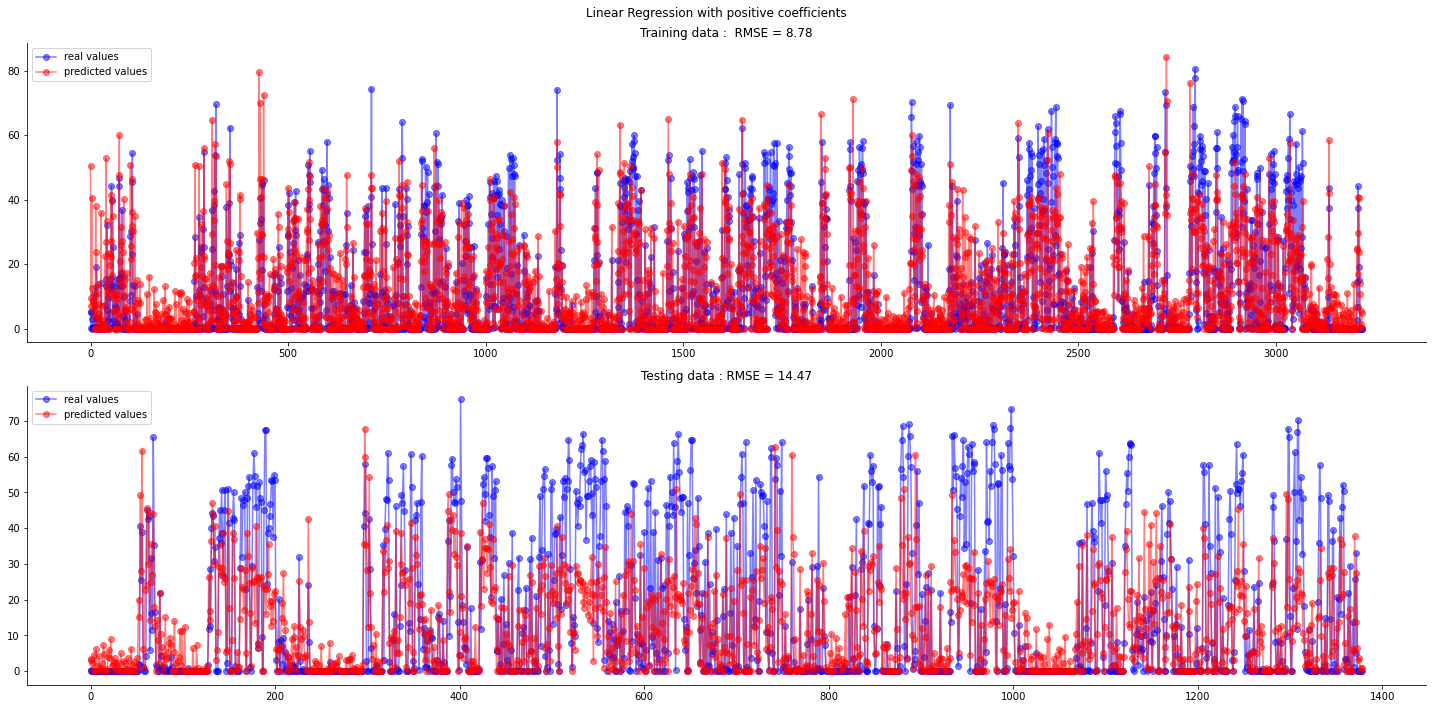

In [44]:
y_train_pred      = my_model_LR_2.predict(X_train_pca) # metric_train_RMSE: 2.4037369030804003e-05


y_train_pred[y_train_pred<=0] = 0  # metric_train_RMSE: 2.196909835364599e-05


metric_train_R2   = my_model_LR_2.score(X_train_pca, y_train)
metric_train_RMSE = mean_squared_error(y_train, y_train_pred, squared=False)

print("metric_train_R2  :",metric_train_R2)
print("metric_train_RMSE:",metric_train_RMSE)

fig = plt.figure(figsize=(20,10))


plt.subplot(2,1,1)
plt.plot(range(len(y_train)),y_train,'-bo',alpha=0.5,label='real values')
plt.plot(range(len(y_train_pred)),y_train_pred,'-ro',alpha=0.5,label='predicted values')

plt.legend(loc="upper left")
plt.title('Training data :  RMSE = '+str(np.round(metric_train_RMSE,2)))
#plt.show()


y_test_pred      = my_model_LR_2.predict(X_test_pca) # metric_test_RMSE: 5.73526388441703

y_test_pred[y_test_pred<=0] = 0 #metric_test_RMSE: 5.5218955408988


metric_test_R2   = my_model_LR_2.score(X_test_pca, y_test)
metric_test_RMSE = mean_squared_error(y_test, y_test_pred, squared=False)

print("metric_test_R2  :",metric_test_R2)
print("metric_test_RMSE:",metric_test_RMSE)

#fig = plt.figure(figsize=(20,5))
plt.subplot(2,1,2)
plt.plot(range(len(y_test)),y_test,'-bo',alpha=0.5,label='real values')
plt.plot(range(len(y_test_pred)),y_test_pred,'-ro',alpha=0.5,label='predicted values')
plt.title('Testing data : RMSE = '+str(np.round(metric_test_RMSE,2)))
plt.legend(loc="upper left")

plt.suptitle('Linear Regression with positive coefficients')
plt.show()


In [38]:
from sklearn.model_selection import KFold

metric_train_RMSE: 8.843537223240903
metric_test_RMSE: 8.150280359722435


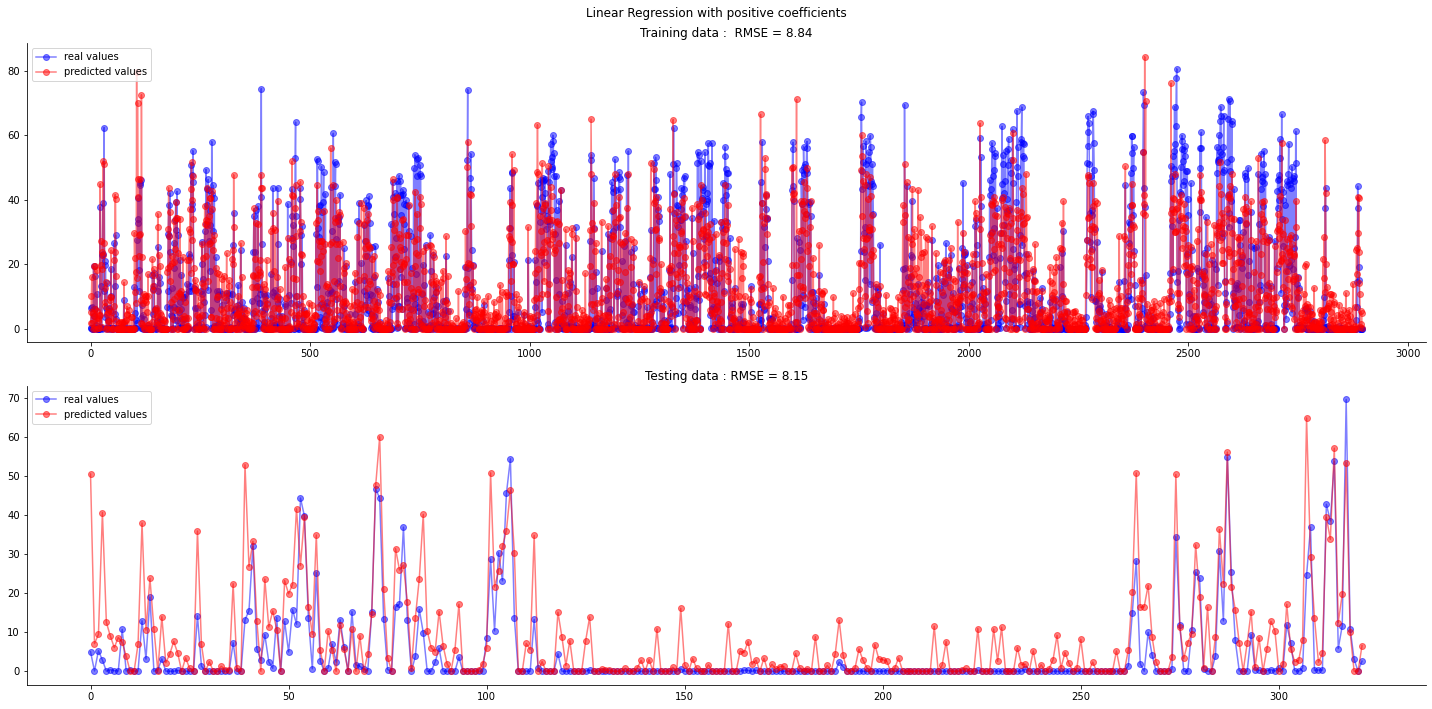

metric_train_RMSE: 8.866290313018203
metric_test_RMSE: 7.924754992236118


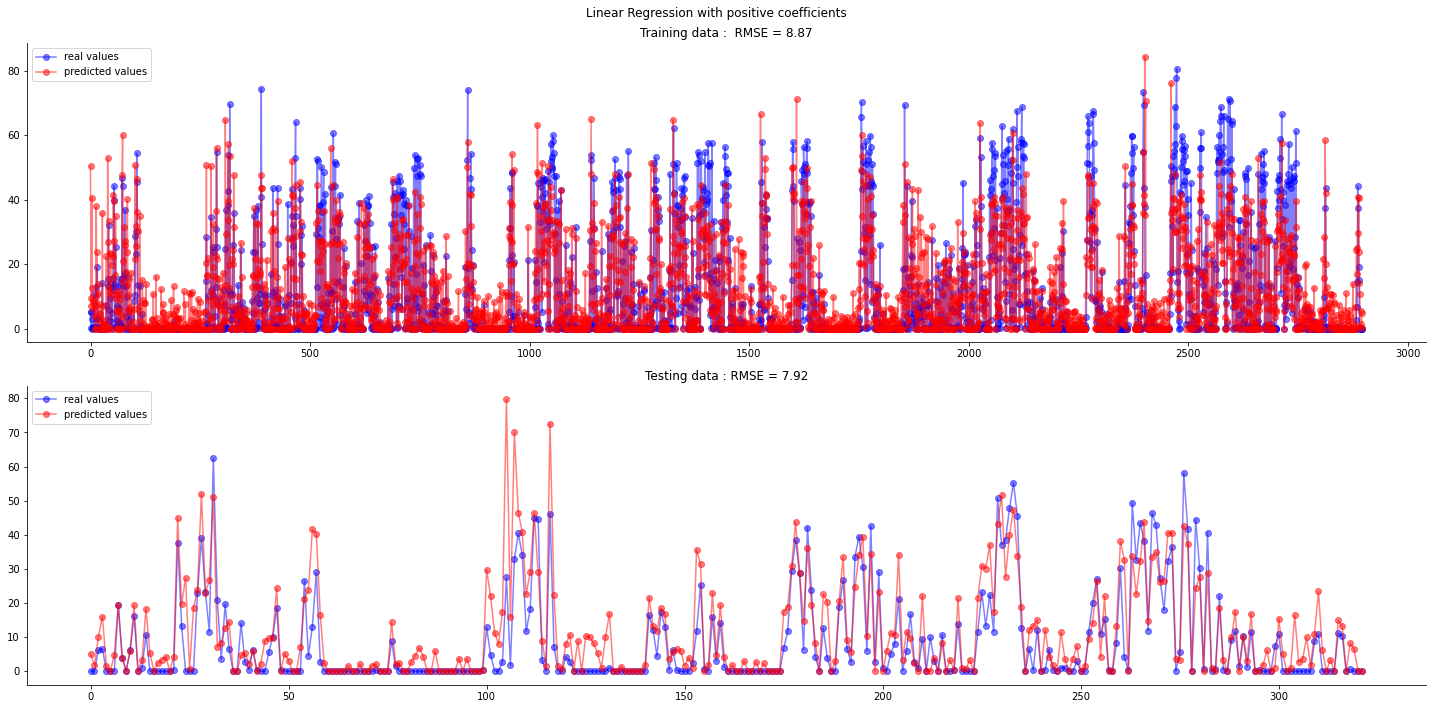

metric_train_RMSE: 8.91931226636249
metric_test_RMSE: 7.370035538040968


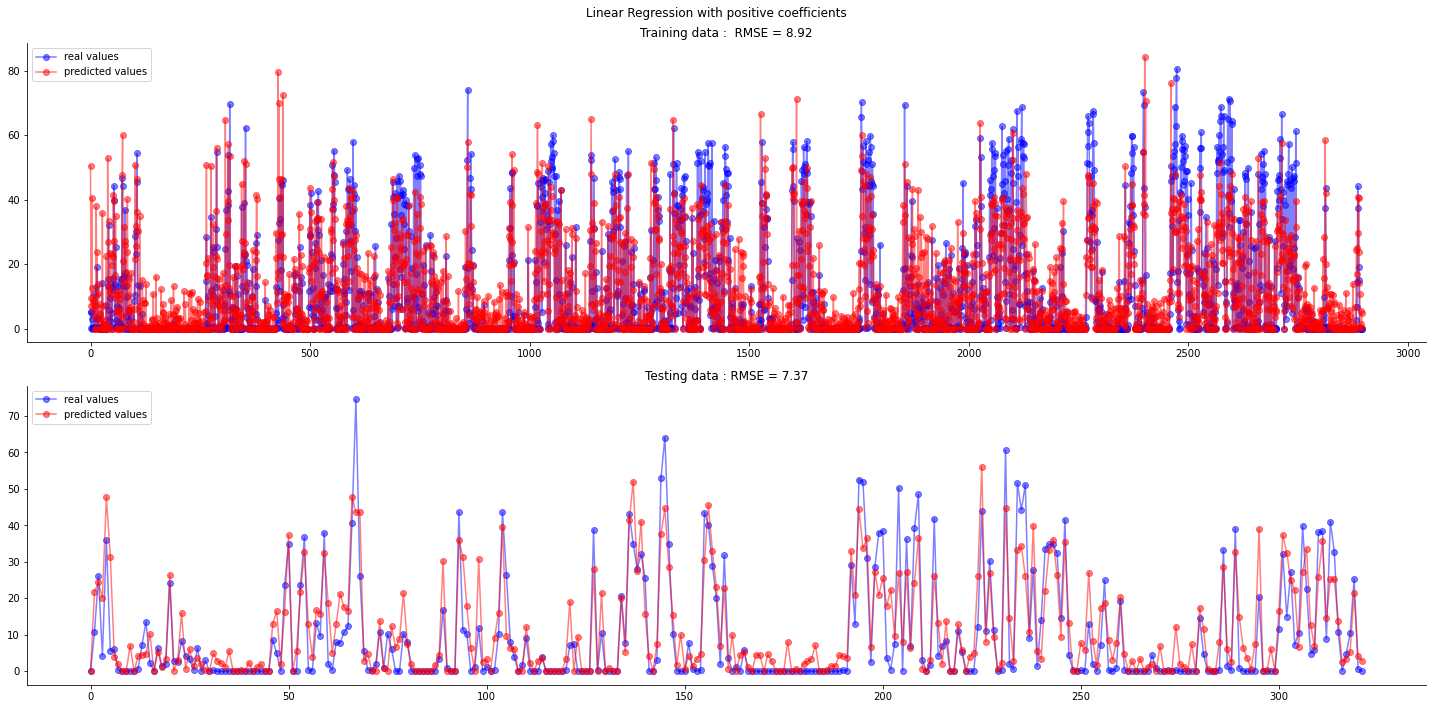

metric_train_RMSE: 8.965651443662953
metric_test_RMSE: 6.845511458358


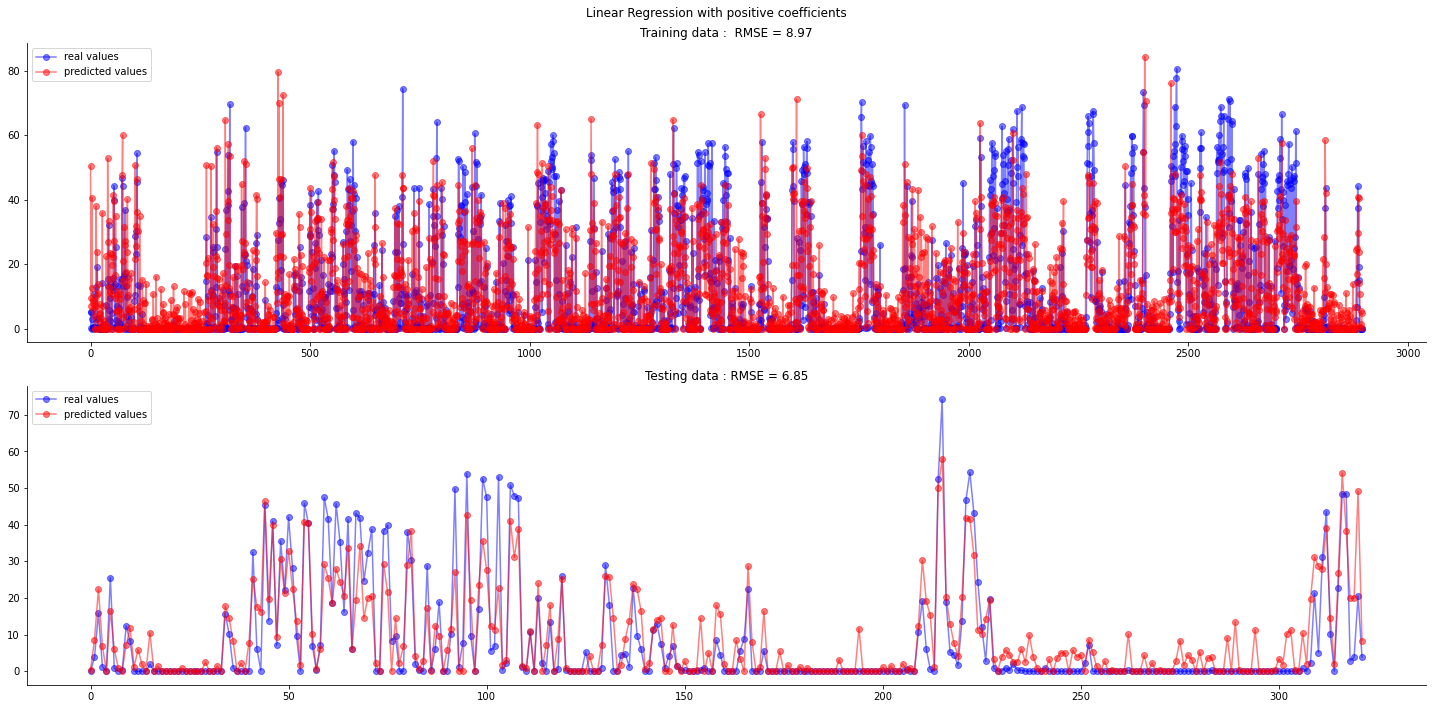

metric_train_RMSE: 8.87056312502549
metric_test_RMSE: 7.881617910359032


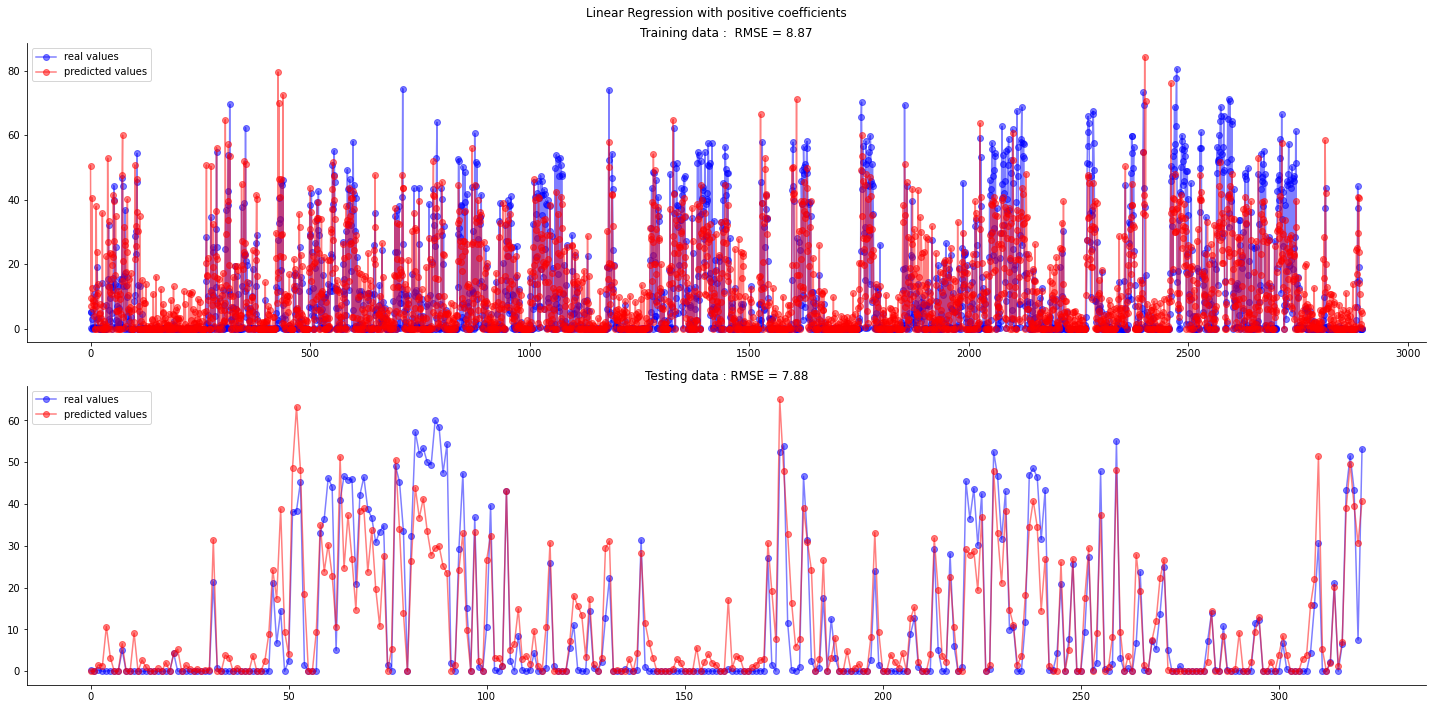

metric_train_RMSE: 8.755434429031746
metric_test_RMSE: 8.965317722587846


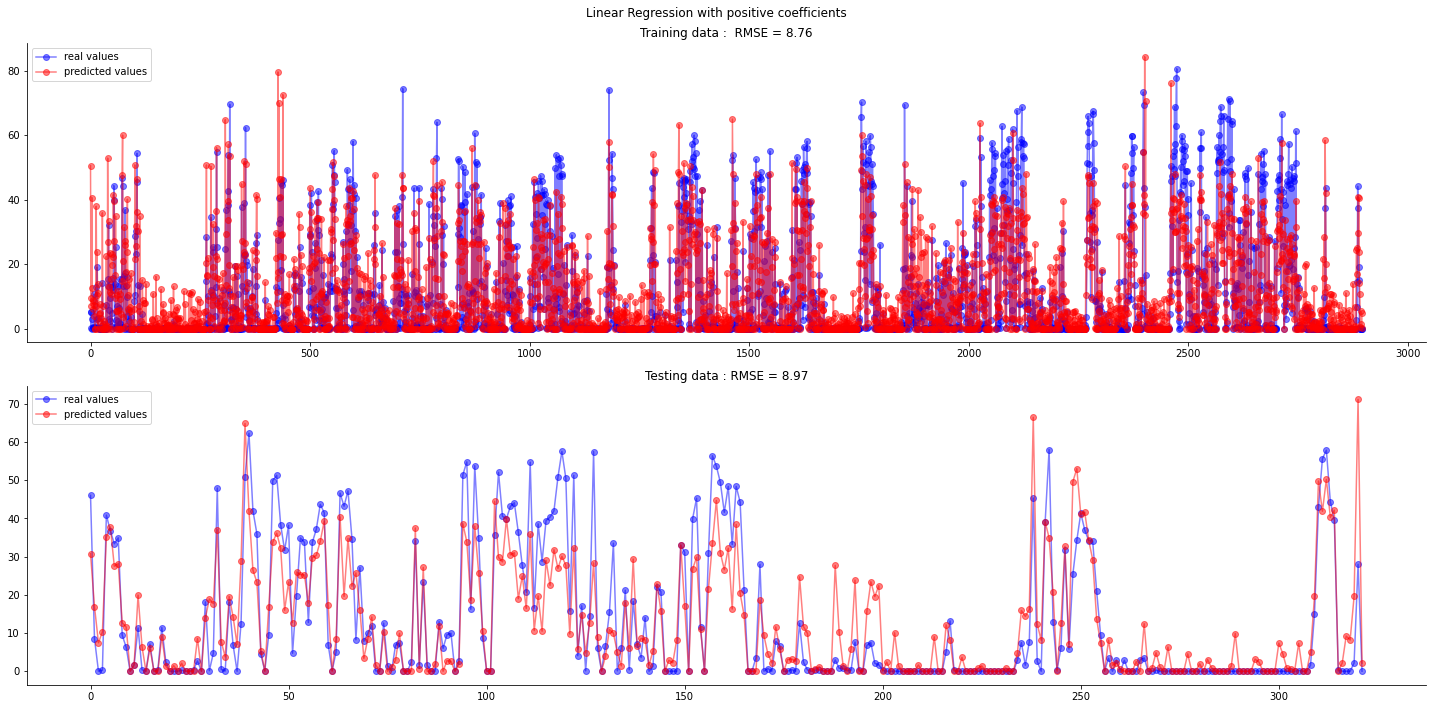

metric_train_RMSE: 8.855252977268139
metric_test_RMSE: 8.035018472136098


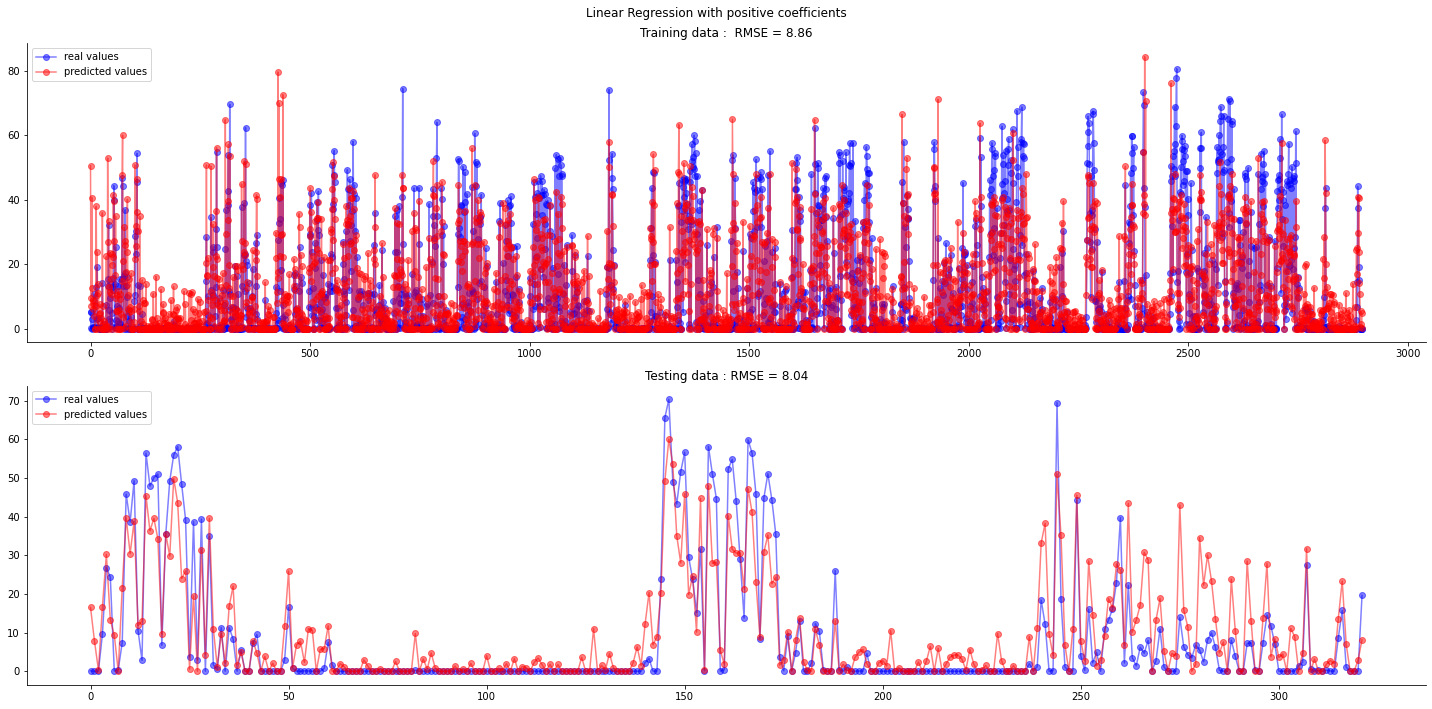

metric_train_RMSE: 8.72201925501567
metric_test_RMSE: 9.253713717772568


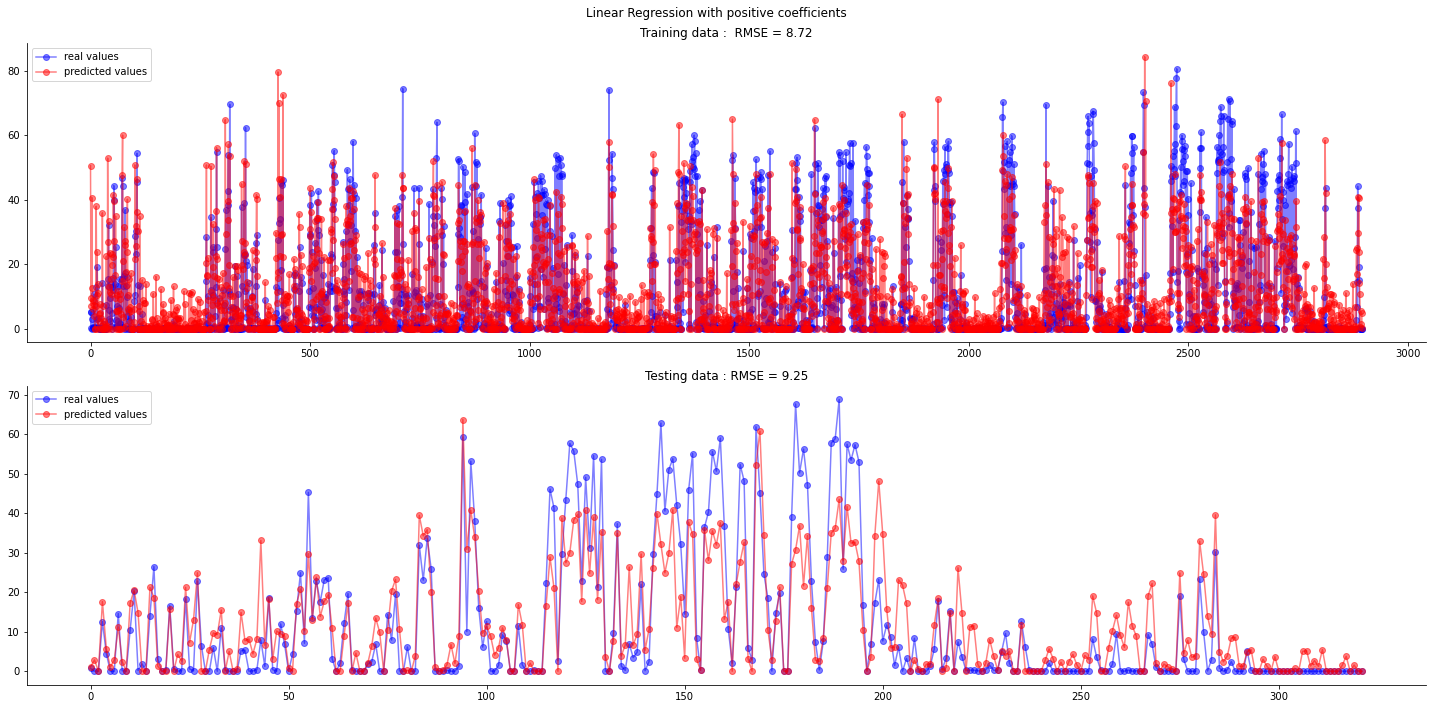

metric_train_RMSE: 8.350482194294822
metric_test_RMSE: 11.94567376389015


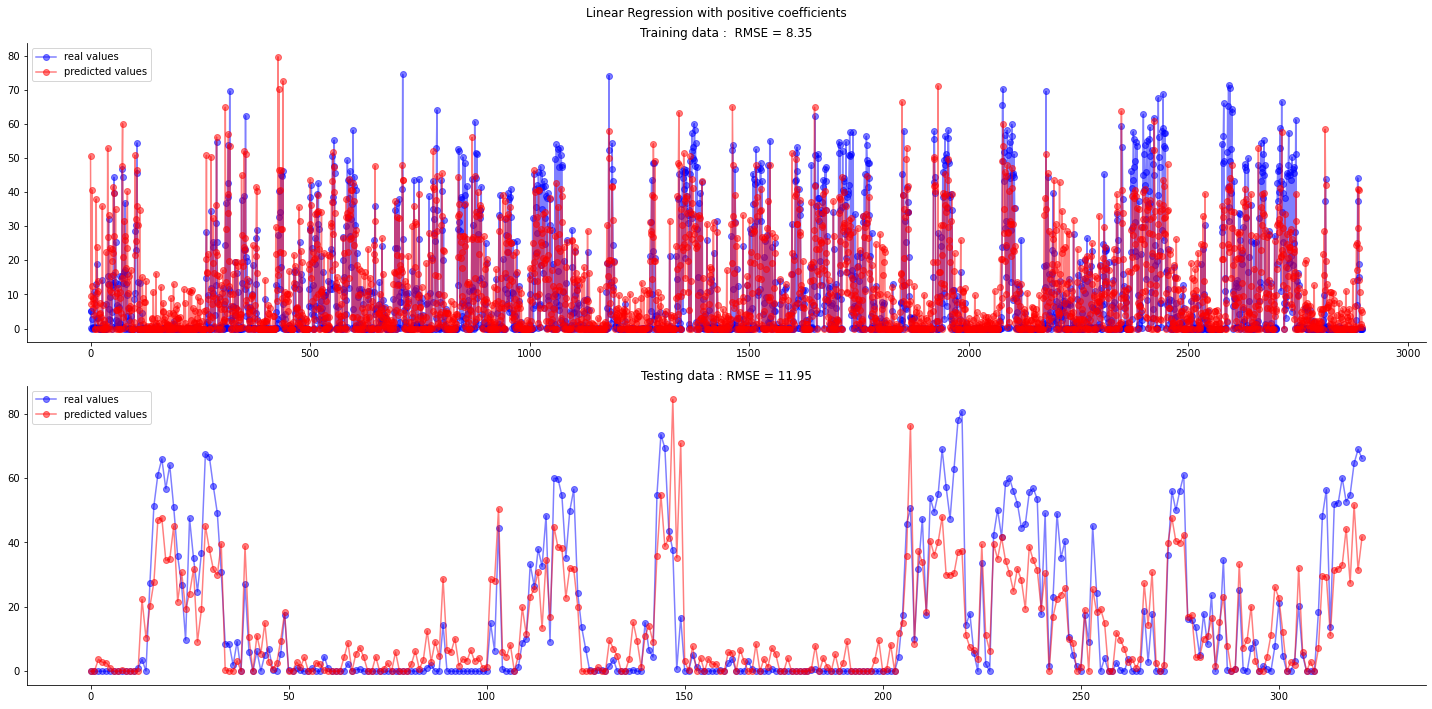

metric_train_RMSE: 8.601007346886371
metric_test_RMSE: 10.22674919548366


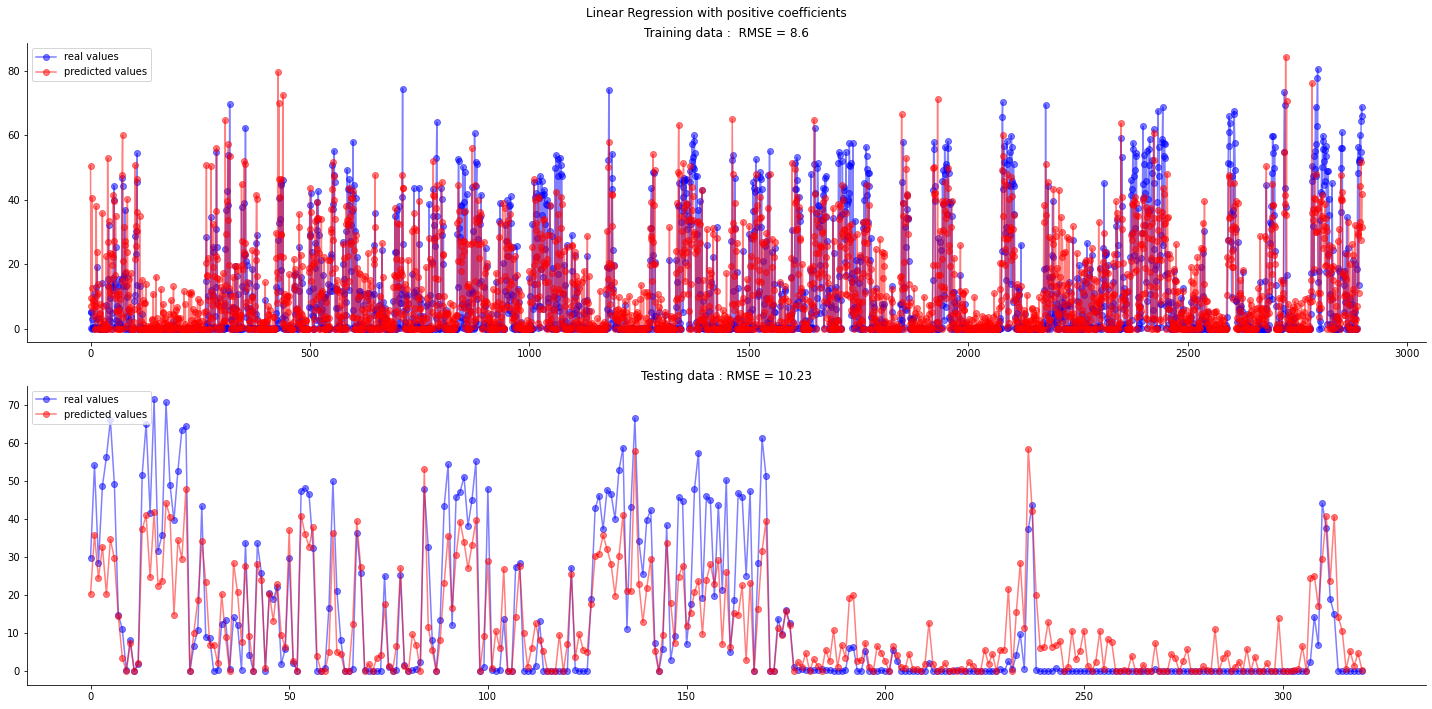

In [47]:
def cross_validate(x_train, y_train, n_splits):
    """ Compute MSE for k-fold validation for each order polynomial

    Args:
    x_train (ndarray): training data input vector of shape (n_samples)
    y_train (ndarray): training vector of measurements of shape (n_samples)
    max_order (scalar): max order of polynomial fit
    n_split (scalar): number of folds for k-fold validation

    Return:
    ndarray: MSE over splits for each model order, shape (n_splits, max_order + 1)

    """

  # Initialize the split method
    kfold_iterator = KFold(n_splits)

  # Initialize np array mse values for all models for each split
  #mse_all = np.zeros((n_splits, 1))
  
    metric_train_rmse_arr= []
    metric_test_rmse_arr= []

    for i_split, (train_indices, val_indices) in enumerate(kfold_iterator.split(x_train)):

      # Split up the overall training data into cross-validation training and validation sets
      x_cv_train = x_train[train_indices]
      y_cv_train = y_train[train_indices]
      x_cv_val = x_train[val_indices]
      y_cv_val = y_train[val_indices]
    
      y_train_pred = my_model_LR_2.predict(x_cv_train) # metric_train_RMSE: 2.4037369030804003e-05


      y_train_pred[y_train_pred<=0] = 0  # metric_train_RMSE: 2.196909835364599e-05


      metric_train_R2   = my_model_LR_2.score(x_cv_train, y_cv_train)
      metric_train_RMSE = mean_squared_error(y_cv_train, y_train_pred, squared=False)
      metric_train_rmse_arr.append(metric_train_RMSE)
      

      #print("metric_train_R2  :", metric_train_R2)
      print("metric_train_RMSE:",metric_train_RMSE)

      fig = plt.figure(figsize=(20,10))


      plt.subplot(2,1,1)
      plt.plot(range(len(y_cv_train)),y_cv_train,'-bo',alpha=0.5,label='real values')
      plt.plot(range(len(y_train_pred)),y_train_pred,'-ro',alpha=0.5,label='predicted values')

      plt.legend(loc="upper left")
      plt.title('Training data :  RMSE = '+str(np.round(metric_train_RMSE,2)))
      #plt.show()


      y_test_pred      = my_model_LR_2.predict(x_cv_val) # metric_test_RMSE: 5.73526388441703

      y_test_pred[y_test_pred<=0] = 0 #metric_test_RMSE: 5.5218955408988


      metric_test_R2   = my_model_LR_2.score(x_cv_val, y_cv_val)
      metric_test_RMSE = mean_squared_error(y_cv_val, y_test_pred, squared=False)

      #print("metric_test_R2  :",metric_test_R2)
      print("metric_test_RMSE:",metric_test_RMSE)
      
      metric_test_rmse_arr.append(metric_test_RMSE)
      plt.subplot(2,1,2)
      plt.plot(range(len(y_cv_val)),y_cv_val,'-bo',alpha=0.5,label='real values')
      plt.plot(range(len(y_test_pred)),y_test_pred,'-ro',alpha=0.5,label='predicted values')
      plt.title('Testing data : RMSE = '+str(np.round(metric_test_RMSE,2)))
      plt.legend(loc="upper left")

      plt.suptitle('Linear Regression with positive coefficients')
      plt.show()




      

      

    return metric_test_rmse_arr


# Cross-validate
#max_order = 1
n_splits = 10
mse_all = cross_validate(X_train_pca, y_train, n_splits)


